### LAB 9-3: 고급 CNN을 가져다 써보자.

In [2]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers 
from keras.models import Model, load_model 
import pandas as pd
from tensorflow.keras.optimizers import RMSprop

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 훈련데이터는 10000개, 검증 데이터는 2000개만 사용
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3), 
                              dtype=np.float32)
print(x_train_preprocess.shape)
# 훈련 데이터 각각의 크기를 75x75로 변형 (인셉션 모델의 최소 크기)
for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(10000, 75, 75, 3)


In [8]:
x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3), 
                             dtype=np.float32)
print(x_test_preprocess.shape)
# 검증 데이터 각각의 크기를 75x75로 변형 (인셉션모델 최소 입력 크기)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(2000, 75, 75, 3)


In [9]:
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(10, activation='sigmoid')(x)

In [11]:
model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
history = model.fit(x_train_preprocess, y_train, epochs=20, 
                    validation_data=(x_test_preprocess, y_test))

Epoch 1/20
313/313 [==============================] - 36s 54ms/step - loss: 1.2626 - accuracy: 0.7956 - val_loss: 12.0517 - val_accuracy: 0.5100
Epoch 2/20
313/313 [==============================] - 15s 47ms/step - loss: 0.2880 - accuracy: 0.9352 - val_loss: 49.6115 - val_accuracy: 0.4370
Epoch 3/20
313/313 [==============================] - 15s 49ms/step - loss: 0.1804 - accuracy: 0.9611 - val_loss: 0.8378 - val_accuracy: 0.9210
Epoch 4/20
313/313 [==============================] - 15s 48ms/step - loss: 0.1714 - accuracy: 0.9672 - val_loss: 1.1034 - val_accuracy: 0.9000
Epoch 5/20
313/313 [==============================] - 15s 48ms/step - loss: 0.1415 - accuracy: 0.9745 - val_loss: 0.1993 - val_accuracy: 0.9665
Epoch 6/20
313/313 [==============================] - 15s 47ms/step - loss: 0.1586 - accuracy: 0.9780 - val_loss: 1.0534 - val_accuracy: 0.8905
Epoch 7/20
313/313 [==============================] - 15s 47ms/step - loss: 0.1205 - accuracy: 0.9793 - val_loss: 0.6875 - val_accurac

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

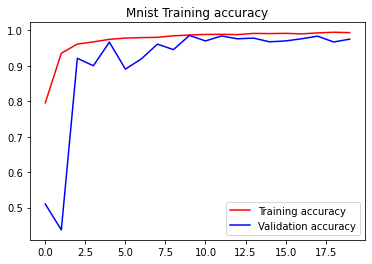

<Figure size 432x288 with 0 Axes>

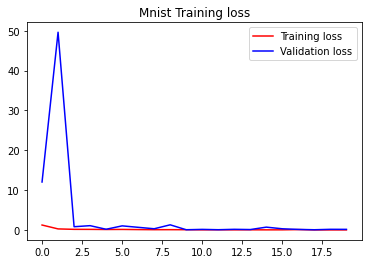

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(x_test_preprocess, y_test, verbose=2)
print('테스트 정확도:', test_acc)

63/63 - 1s - loss: 0.1771 - accuracy: 0.9750 - 1s/epoch - 16ms/step
테스트 정확도: 0.9750000238418579


### 9.9 전이학습 - 이미 훈련된 모델을 고쳐 쓰기

In [17]:
# LAB9.3에서 데이터를 읽는 것까지는
# 그대로 진행한 뒤에 전이학습 코드를 새로 작성한다.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers 
from keras.models import Model, load_model 
import pandas as pd
from tensorflow.keras.optimizers import RMSprop

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3), 
                              dtype=np.float32)
print(x_train_preprocess.shape)

for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3), 
                             dtype=np.float32)
print(x_test_preprocess.shape)
# 검증 데이터 각각의 크기를 75x75로 변형 (인셉션모델 최소 입력 크기)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

(10000, 75, 75, 3)
(2000, 75, 75, 3)


In [18]:
# 사전 훈련된 모델을 가져온다. - 이미지넷 데이터로 학습된 모델
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                              include_top=False,
                              weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [20]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(lr=0.0005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_94[0]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 activation_100 (Activation)    (None, 7, 7, 48)     0           ['batch_normalization_100[0][0]']
                                                                                                  
 activation_103 (Activation)    (None, 7, 7, 96)     0           ['batch_normalization_103[0][0]']
                                                                                                  
 average_pooling2d_9 (AveragePo  (None, 7, 7, 192)   0           ['max_pooling2d_5[0][0]']        
 oling2D)                                                                                         
                                                                                                  
 conv2d_99 (Conv2D)             (None, 7, 7, 64)     12288       ['max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_101 (Conv2D)            (None, 7, 7, 64)     76800       ['activation_100[0][0]']         
          

In [21]:
history = model.fit(x_train_preprocess, y_train, epochs=20, 
                    validation_data=(x_test_preprocess, y_test))

Epoch 1/20
313/313 [==============================] - 14s 32ms/step - loss: 0.2934 - accuracy: 0.9188 - val_loss: 0.1651 - val_accuracy: 0.9480
Epoch 2/20
313/313 [==============================] - 6s 19ms/step - loss: 0.0837 - accuracy: 0.9730 - val_loss: 0.0823 - val_accuracy: 0.9740
Epoch 3/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0568 - accuracy: 0.9811 - val_loss: 0.0790 - val_accuracy: 0.9740
Epoch 4/20
313/313 [==============================] - 5s 17ms/step - loss: 0.0414 - accuracy: 0.9863 - val_loss: 0.2777 - val_accuracy: 0.9195
Epoch 5/20
313/313 [==============================] - 6s 18ms/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.0844 - val_accuracy: 0.9725
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.1021 - val_accuracy: 0.9715
Epoch 7/20
313/313 [==============================] - 5s 17ms/step - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.0914 - val_accuracy: 0.971

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

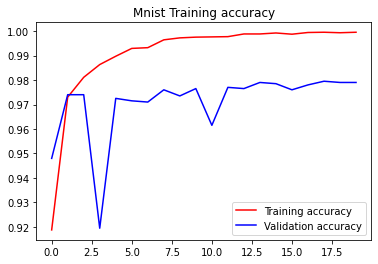

<Figure size 432x288 with 0 Axes>

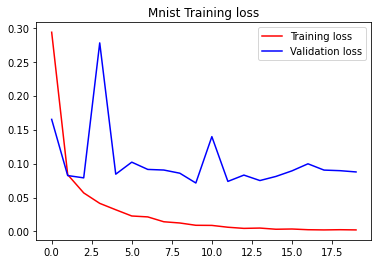

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(x_test_preprocess, y_test, verbose=2)
print('테스트 정확도:', test_acc)

63/63 - 1s - loss: 0.0877 - accuracy: 0.9790 - 916ms/epoch - 15ms/step
테스트 정확도: 0.9789999723434448


### 9장 미니 프로젝트 B2 얼굴 찾기 : CNN 활용하기

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

In [3]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

face_images = []

for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    face_images.append(img)

In [5]:
print(np.array(face_images).shape)  # 리스트 형태라서 numpy로 변환시켜 shape 확인

(15, 64, 64, 3)


<Figure size 432x288 with 0 Axes>

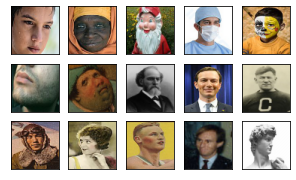

In [6]:
def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

plot_images(3,5, face_images)

<Figure size 432x288 with 0 Axes>

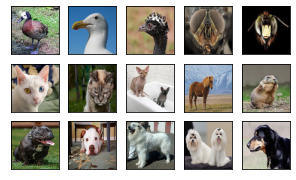

In [7]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []

for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    animal_images.append(img)

plot_images(3,5, animal_images)

In [9]:
X =face_images + animal_images
y = [ [1,0] ]* len(face_images) + [ [0,1]] * len(animal_images) # one-hot encoding
X = np.array(X) 
y = np.array(y)
print(X.shape, y.shape)

(30, 64, 64, 3) (30, 2)


In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

model = keras.models.Sequential( [
    keras.layers.Conv2D(input_shape = (64, 64, 3), 
                        kernel_size = (3,3), filters = 32),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), filters = 32),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), filters = 32),
    keras.layers.MaxPooling2D((2, 2), strides=2),
    keras.layers.Conv2D(kernel_size = (3,3), filters = 32),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(2, activation = 'softmax'), #출력노드 2, 활성함수 softmax
])

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # 벡터로 줬기 때문에 categorical_crossentropy
history = model.fit(X, y, epochs = 100)

Epoch 1/100
1/1 [==============================] - 1s 518ms/step - loss: 0.7045 - accuracy: 0.4333
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6844 - accuracy: 0.4667
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6588 - accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6222 - accuracy: 0.6667
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5888 - accuracy: 0.8000
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.5708 - accuracy: 0.6333
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 0.5558 - accuracy: 0.7333
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.4939 - accuracy: 0.9000
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.4792 - accuracy: 0.8667
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 0.4484 - accuracy: 0.8333
Epoch 11/100
1/1 [

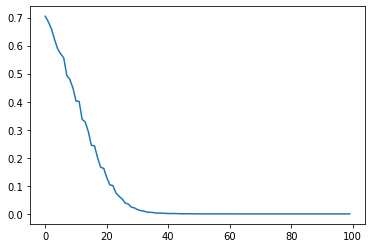

In [23]:
plt.plot(history.history['loss'])

<Figure size 432x288 with 0 Axes>

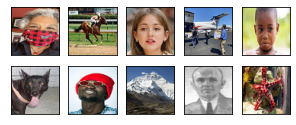

In [24]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []

for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (64,64))
    test_images.append(img)

test_images = np.array(test_images)
plot_images(2, 5, test_images)

[[9.7776198e-01 2.2238052e-02]
 [2.6801147e-04 9.9973196e-01]
 [9.9999940e-01 5.4358537e-07]
 [1.7474799e-10 1.0000000e+00]
 [9.9173671e-01 8.2633020e-03]
 [7.3088482e-02 9.2691153e-01]
 [9.9999440e-01 5.6155482e-06]
 [2.4985491e-08 1.0000000e+00]
 [5.9684908e-01 4.0315089e-01]
 [3.3883940e-02 9.6611607e-01]]
[[0.98 0.02]
 [0.   1.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.99 0.01]
 [0.07 0.93]
 [1.   0.  ]
 [0.   1.  ]
 [0.6  0.4 ]
 [0.03 0.97]]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


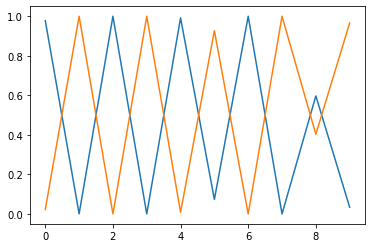

In [28]:
test_result = model.predict(test_images)
print(test_result) # 예측한 값 출력
print(np.round(test_result, 2)) # 소수점 둘째 자리까지
print([np.argmax(c) for c in test_result]) # 타겟에 대한 인덱스 값 출력, 얼굴은 0, 동물은 1
plt.plot(test_result)

<Figure size 432x288 with 0 Axes>

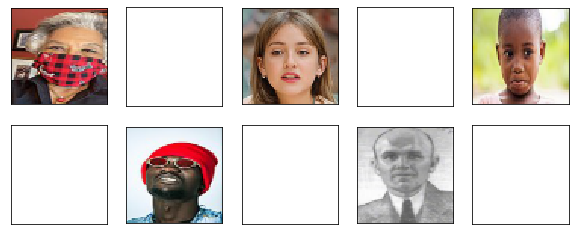

In [29]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j][0] > 0.5:
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

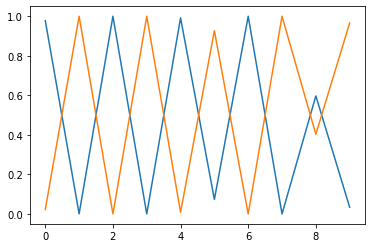

In [30]:
test_result = model.predict(test_images)
plt.plot(test_result)

### 9장 미니 프로젝트 B3 얼굴 찾기 : 전이학습 활용하기

In [31]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread             # 이미지를 읽어 들인다
from skimage.transform import resize      # 이미지의 크기를 변경할 수 있다

In [32]:
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model

In [33]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/faces/'

<Figure size 432x288 with 0 Axes>

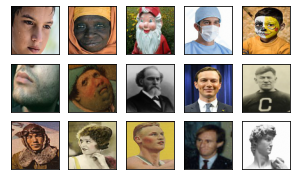

In [34]:
face_images = []
for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    face_images.append(img)

def plot_images(nRow, nCol, img):
    fig = plt.figure()
    fig, ax = plt.subplots(nRow, nCol, figsize = (nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i, j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

plot_images(3,5, face_images)

<Figure size 432x288 with 0 Axes>

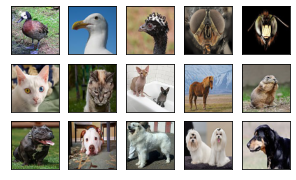

In [35]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/animals/'

animal_images = []
for i in range(15):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    animal_images.append(img)

plot_images(3,5, animal_images)

In [36]:
X = face_images + animal_images
# 얼굴 이미지는 1, 얼굴이 아닌 이미지는 0 - sparse_categorical_entropy 
y = [[1]]* len(face_images) + [[0]] * len(animal_images)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(30, 75, 75, 3) (30, 1)


In [39]:
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                                include_top=False,
                                weights=None) #가중치를 가져오지 않았기 때문에 아직 전이학습이라고 할 수 없음

In [40]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_102 (Conv2D)            (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_102[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_

In [41]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

In [42]:
model = Model(pre_trained_model.input, my_layer)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_102 (Conv2D)            (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_102[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_94[0][0

In [44]:
history = model.fit(X, y, epochs=100, shuffle=True)

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 0.2869 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.4952 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 0.4815 - accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2299 - accuracy: 0.6333
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 0.3497 - accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0498 - accuracy: 0.9667
Epoch 7/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0512 - accuracy: 0.9667
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0336 - accuracy: 0.9667
Epoch 9/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0334 - accuracy: 0.9667
Epoch 10/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0334 - accuracy: 0.9667
Epoch 11/100
1/1 [=

[[0.8075652 ]
 [0.84306604]
 [0.7939932 ]
 [0.79694796]
 [0.75180036]
 [0.8255385 ]
 [0.79826003]
 [0.7659435 ]
 [0.6394666 ]
 [0.85024875]]


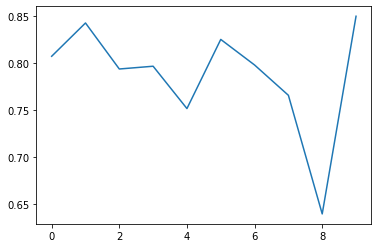

<Figure size 432x288 with 0 Axes>

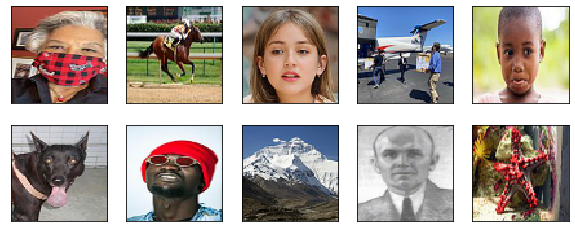

In [46]:
url = 'https://github.com/dknife/ML/raw/main/data/Proj2/test_data/'

test_images = []
for i in range(10):
    file = url + 'img{0:02d}.jpg'.format(i+1)
    img = imread(file)
    img = resize(img, (75,75))
    test_images.append(img)

test_images = np.array(test_images)
test_result = model.predict(test_images)
print(test_result)
plt.plot(test_result)

fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

# 대부분 사진이 안나오는 경우가 많다. 다만 출력이 된 경우는 제대로 된 학습이 되지 않은 상태로 출력되지 않는다.

In [47]:
frozen = InceptionV3(input_shape=(75, 75, 3),
                     include_top=False,
                     weights='imagenet')
last_layer = frozen.get_layer('mixed7')
last_output = last_layer.output

for layer in frozen.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [48]:
my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(256, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

transfer_learner = Model(frozen.input, my_layer)
transfer_learner.summary()
transfer_learner.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 37, 37, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 37, 37, 32)  96          ['conv2d_196[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_188 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_188[0

In [49]:
history = transfer_learner.fit(X, y, epochs=100, shuffle=True)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.2405 - accuracy: 0.6333
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 2.5933e-05 - accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 2.8595e-06 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 6.3280e-07 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 1.8016e-07 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 6.3141e-08 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 2.5409e-08 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 36ms/step - loss: 1.1427e-08 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: 5.5759e-09 - accura

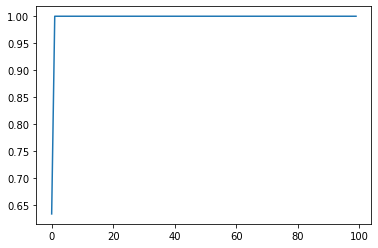

In [50]:
plt.plot(history.history['accuracy'])

[[2.3320747e-06]
 [2.1033131e-10]
 [1.0000000e+00]
 [3.2331334e-06]
 [9.9998736e-01]
 [2.3071149e-09]
 [1.0000000e+00]
 [8.2910587e-14]
 [9.9999952e-01]
 [2.4963393e-07]]


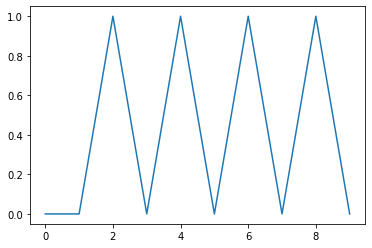

In [52]:
test_result = transfer_learner.predict(test_images)
print(test_result)
plt.plot(test_result)

<Figure size 432x288 with 0 Axes>

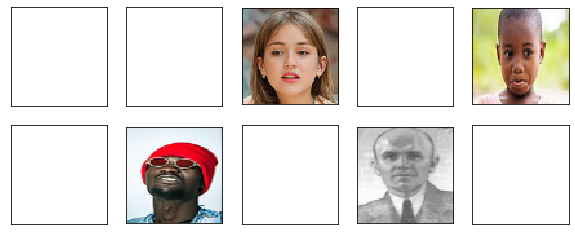

In [53]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')

In [55]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, 
              input_shape=(75, 75, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [58]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [59]:
last_layer = vgg16.get_layer('block4_pool') # block4_pool까지만 
last_output = last_layer.output

for layer in vgg16.layers:
   layer.trainable = False

my_layer = layers.Flatten()(last_output)
my_layer = layers.Dense(32, activation='relu')(my_layer)
my_layer = layers.Dense(32, activation='relu')(my_layer)
my_layer = layers.Dense(1, activation='sigmoid')(my_layer)

transfer_learner = Model(vgg16.input, my_layer)

transfer_learner.compile(optimizer='adam',
                         loss='mse',
                         metrics=['accuracy'])

In [60]:
transfer_learner.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0   

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.4003 - accuracy: 0.4000
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3041 - accuracy: 0.5667
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1585 - accuracy: 0.6333
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0169 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 5.3076e-04 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 26ms/step - loss: 1.2457e-04 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 26ms/step - loss: 6.5251e-05 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 26ms/step - loss: 4.0474e-05 - accuracy: 1.0000
Epoch

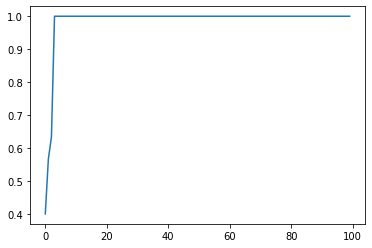

In [61]:
history = transfer_learner.fit(X, y, epochs=100, shuffle=True)
plt.plot(history.history['accuracy'])

[[0.03]
 [0.  ]
 [1.  ]
 [0.  ]
 [1.  ]
 [0.  ]
 [1.  ]
 [0.  ]
 [1.  ]
 [0.05]]


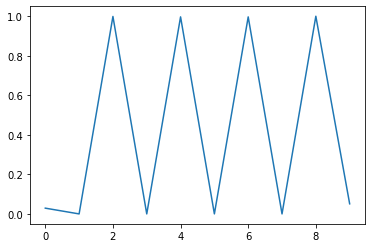

In [64]:
test_result = transfer_learner.predict(test_images)
print(np.round(test_result, 2))
plt.plot(test_result)

<Figure size 432x288 with 0 Axes>

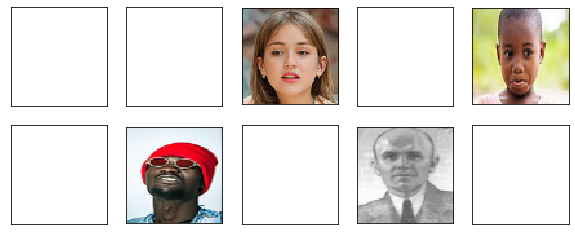

In [63]:
fig = plt.figure()
fig, ax = plt.subplots(2,5, figsize = (10,4))
for i in range(2):
    for j in range(5):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        if test_result[i*5+j] > 0.5:            
            ax[i, j].imshow(test_images[i*5+j],interpolation='nearest')